<a href="https://colab.research.google.com/github/Karanmanolaa/Fire_detection/blob/main/Fire_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
! kaggle datasets download -d phylake1337/fire-dataset

 98% 378M/387M [00:03<00:00, 132MB/s]
100% 387M/387M [00:03<00:00, 112MB/s]


In [4]:
# extracting the compressed dataset
from zipfile import ZipFile

dataset = '/content/fire-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [38]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
plt.style.use('fivethirtyeight')
import os
import cv2
from keras.preprocessing import image

In [6]:
# Create an empty list to store data
data = []

# Loop over fire images and label them as fire
fire_images_path = '/content/fire_dataset/fire_images'
for filename in os.listdir(fire_images_path):
    data.append({'path': os.path.join(fire_images_path, filename), 'label': 'fire'})

# Loop over non fire images and label them as non_fire
non_fire_images_path = '/content/fire_dataset/non_fire_images'
for filename in os.listdir(non_fire_images_path):
    data.append({'path': os.path.join(non_fire_images_path, filename), 'label': 'non_fire'})

df = pd.DataFrame(data)

# Shuffle the dataset to redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)


path     label
0  /content/fire_dataset/non_fire_images/non_fire...  non_fire
1     /content/fire_dataset/fire_images/fire.406.png      fire
2     /content/fire_dataset/fire_images/fire.457.png      fire
3     /content/fire_dataset/fire_images/fire.344.png      fire
4  /content/fire_dataset/non_fire_images/non_fire...  non_fire
5      /content/fire_dataset/fire_images/fire.59.png      fire
6     /content/fire_dataset/fire_images/fire.372.png      fire
7     /content/fire_dataset/fire_images/fire.100.png      fire
8      /content/fire_dataset/fire_images/fire.28.png      fire
9      /content/fire_dataset/fire_images/fire.20.png      fire

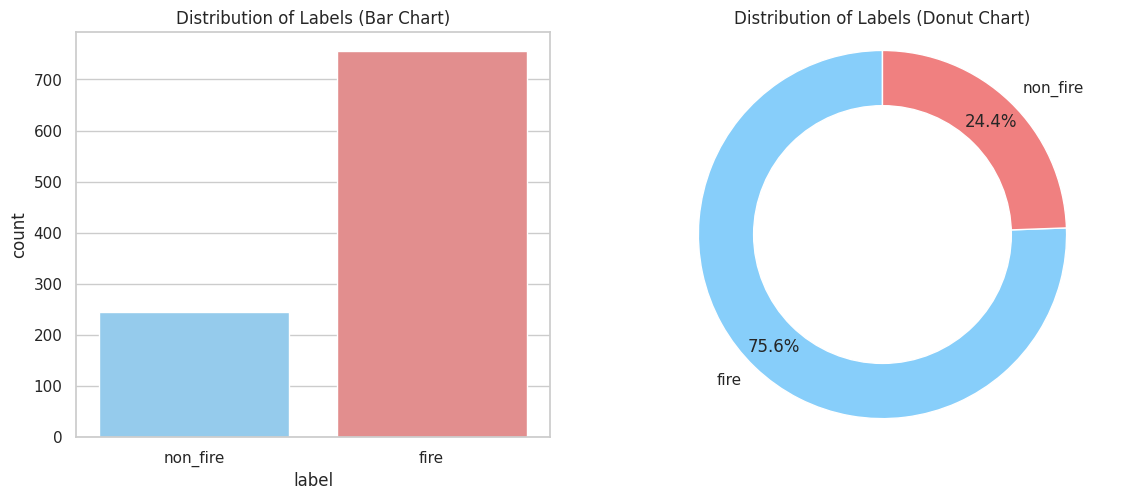

In [8]:
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
bar_colors = ['lightskyblue','lightcoral']
sns.countplot(data=df, x='label', palette=bar_colors, ax=ax1)
ax1.set_title('Distribution of Labels (Bar Chart)')

# Donut chart (Pie chart with a hole)
donut_colors = ['lightskyblue', 'lightcoral']
label_counts = df['label'].value_counts()
ax2.pie(label_counts, labels=label_counts.index, colors=donut_colors, autopct='%1.1f%%',
        startangle=90, pctdistance=0.85)
# Draw a circle at the center to make it a donut chart
center_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(center_circle)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Distribution of Labels (Donut Chart)')

# Display the plots
plt.show()


In [9]:
df['label'].value_counts()

fire        755
non_fire    244
Name: label, dtype: int64

### The number of non fire images are less hence, the dataset is imbalanced

## Sample images with fire

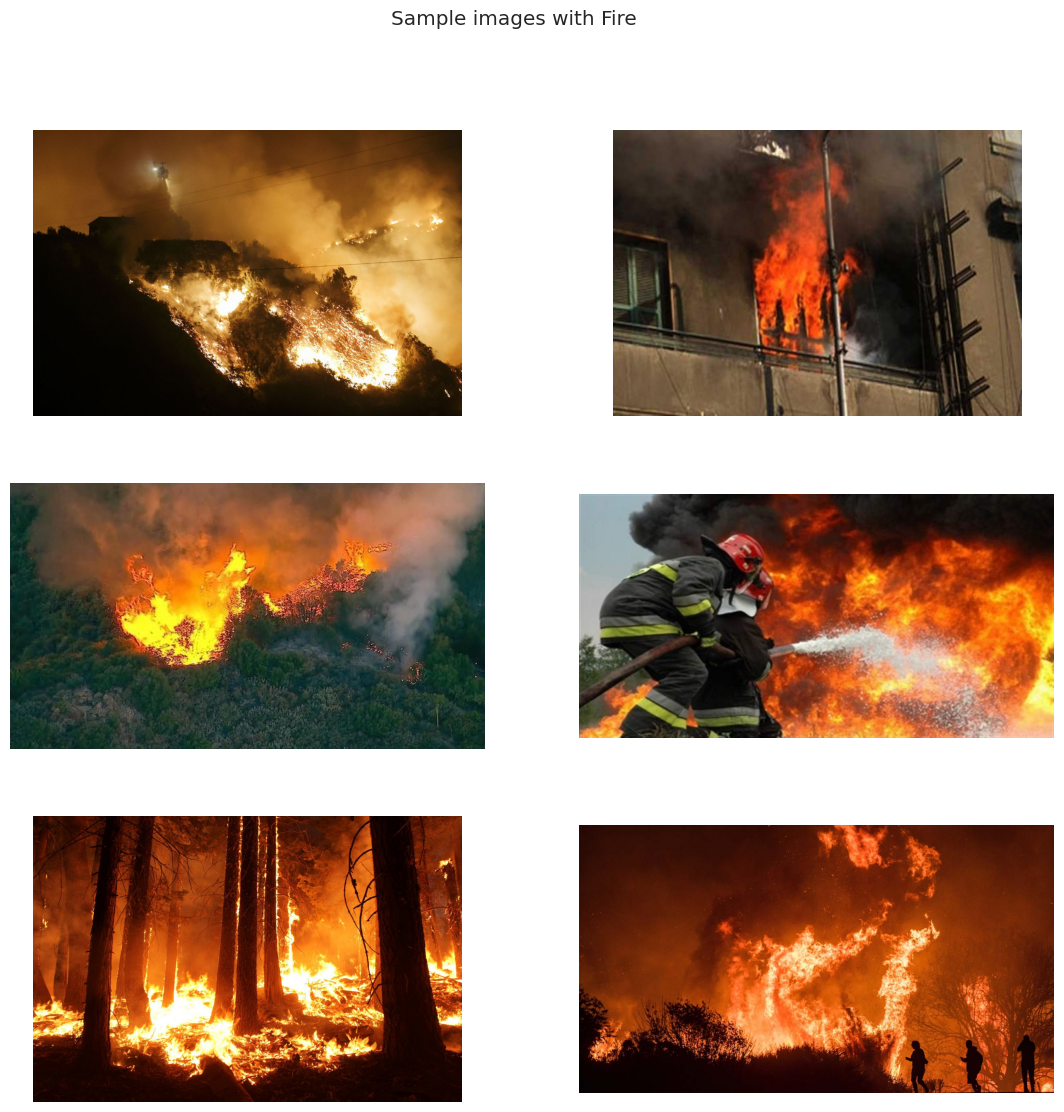

In [10]:
label = 'fire'
data = df[df['label'] == label]
sns.set_style('dark')

pics = 6  # Number of images to display
fig, ax = plt.subplots(3,2, figsize=(12, 12))
plt.suptitle('Sample images with Fire')

# Reshape ax for easier indexing
ax = ax.ravel()

for i in range(pics):
    path = data.sample(1)['path'].values[0]
    img = image.load_img(path)
    img = image.img_to_array(img) / 255
    ax[i].imshow(img)
    ax[i].axis('off')  # Hide axis labels and ticks

plt.show()

## Displaying Non-Fire Sample Images

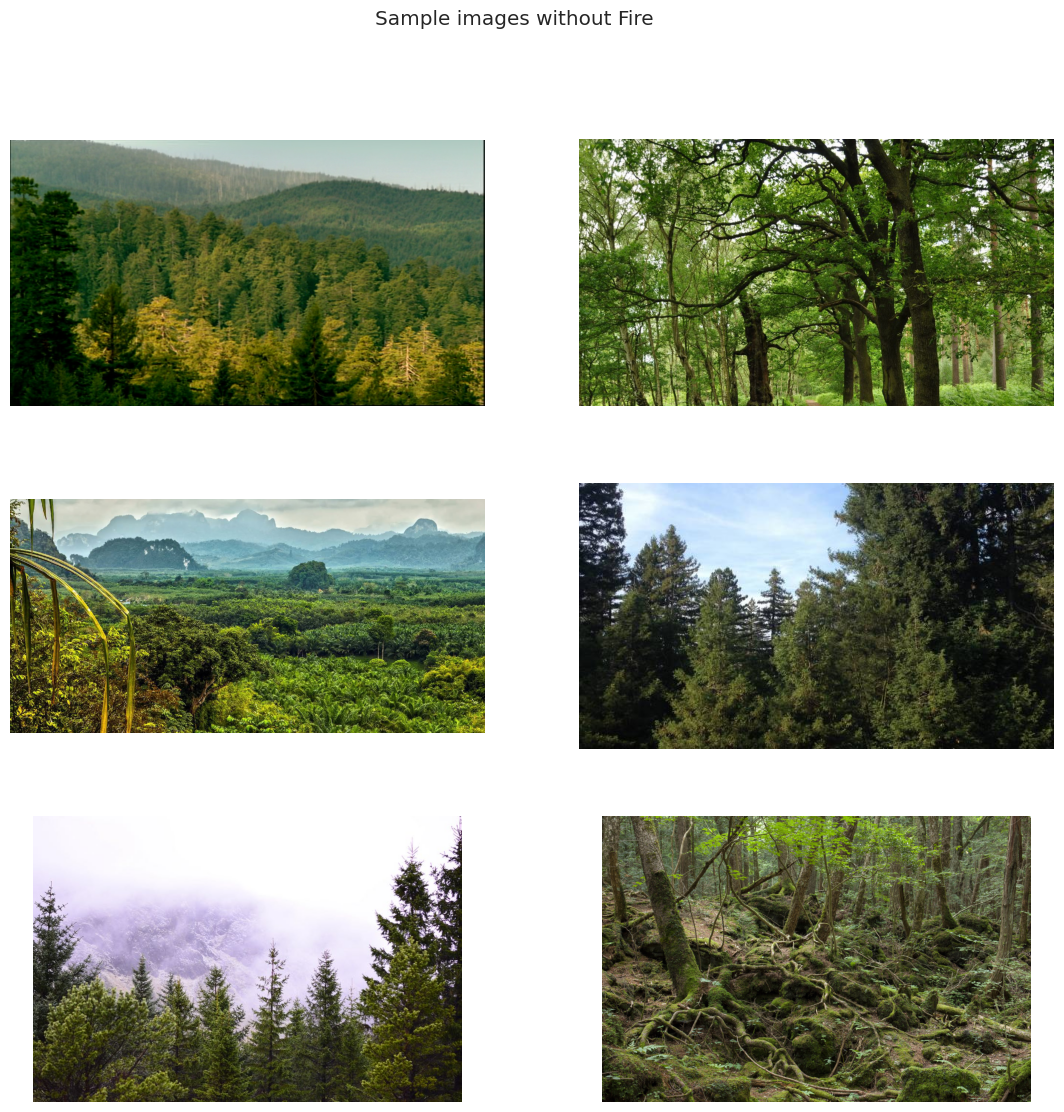

In [11]:
label = 'non_fire'
data = df[df['label'] == label]
sns.set_style('dark')

pics = 6  # Number of images to display
fig, ax = plt.subplots(3,2, figsize=(12, 12))
plt.suptitle('Sample images without Fire')

# Reshape ax for easier indexing
ax = ax.ravel()

for i in range(pics):
    path = data.sample(1)['path'].values[0]
    img = image.load_img(path)
    img = image.img_to_array(img) / 255
    ax[i].imshow(img)
    ax[i].axis('off')  # Hide axis labels and ticks

plt.show()

## Notice that the size of the images are different from each other

In [12]:
def shapes(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shapes,axis=1)
df.sample(5)

path label  height  width
221  /content/fire_dataset/fire_images/fire.513.png  fire     788   1400
662  /content/fire_dataset/fire_images/fire.692.png  fire     240    480
28    /content/fire_dataset/fire_images/fire.58.png  fire    2592   3888
129  /content/fire_dataset/fire_images/fire.142.png  fire     481    660
855  /content/fire_dataset/fire_images/fire.687.png  fire    1266   1900

#### Visualising the shapes of the images

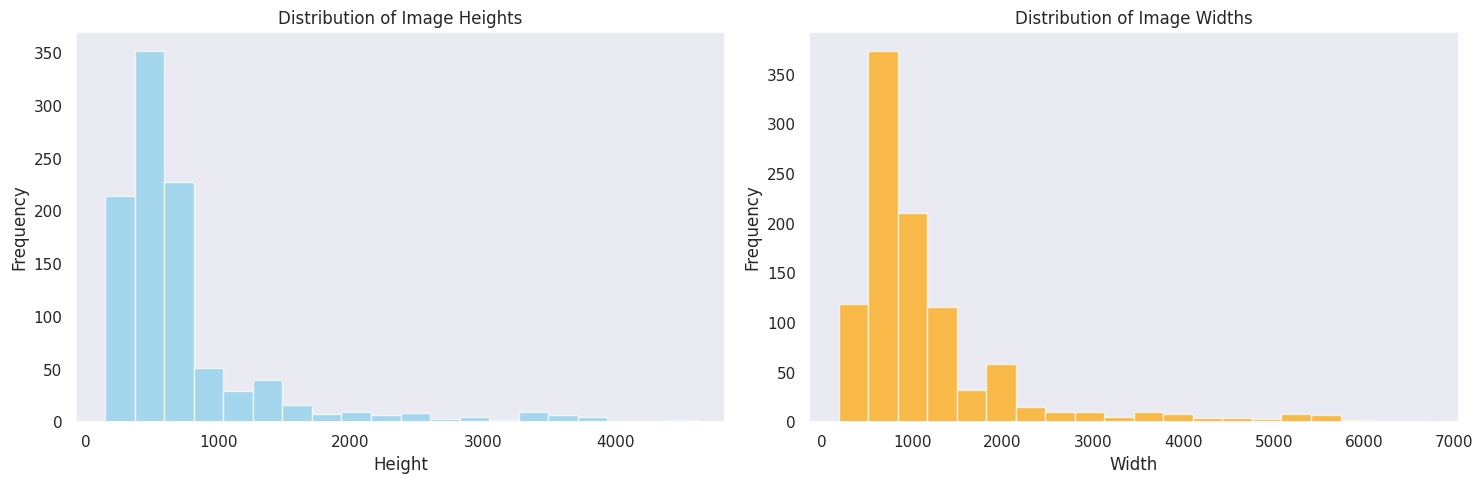

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram for height
ax1.hist(df['height'], bins=20, color='skyblue', alpha=0.7)
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Image Heights')

# Histogram for width
ax2.hist(df['width'], bins=20, color='orange', alpha=0.7)
ax2.set_xlabel('Width')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Image Widths')

plt.tight_layout()
plt.show()

### Before training the model, it's essential to standardize the image dimensions. We will use Data augmentation

## Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

#### We will use the `ImageDataGenerator` class to create data generators.

#### First, we construct two generators, one for training and the other for validation.

#### Note: Our labels are represented as strings 'fire' and 'non_fire', but the image generator will automatically encode them to integer labels.

In [15]:
train_gen = generator.flow_from_dataframe(
    df,                         # DataFrame containing image information
    x_col='path',               # Column with image file paths
    y_col='label',              # Column with labels ('fire' or 'non_fire')
    image_size=(256, 256),      # Target image size
    class_mode='binary',        # Binary classification mode
    subset='training'  ,         # Subset for training data
    classes=['non_fire', 'fire']
)

val_gen = generator.flow_from_dataframe(
    df,                         # DataFrame containing image information
    x_col='path',               # Column with image file paths
    y_col='label',              # Column with labels ('fire' or ' non_fire')
    image_size=(256, 256),      # Target image size
    class_mode='binary',        # Binary classification mode
    subset='validation',       # Subset for validation data
    classes=['non_fire', 'fire']
)

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


#### Class indices assigned by the Image generator

In [16]:
class_indices = {}
for key, value in train_gen.class_indices.items():
    class_indices[value] = key

print(class_indices)

{0: 'non_fire', 1: 'fire'}


#### 0 is assigned for non-fire images whereas 1 is assigned to fire images

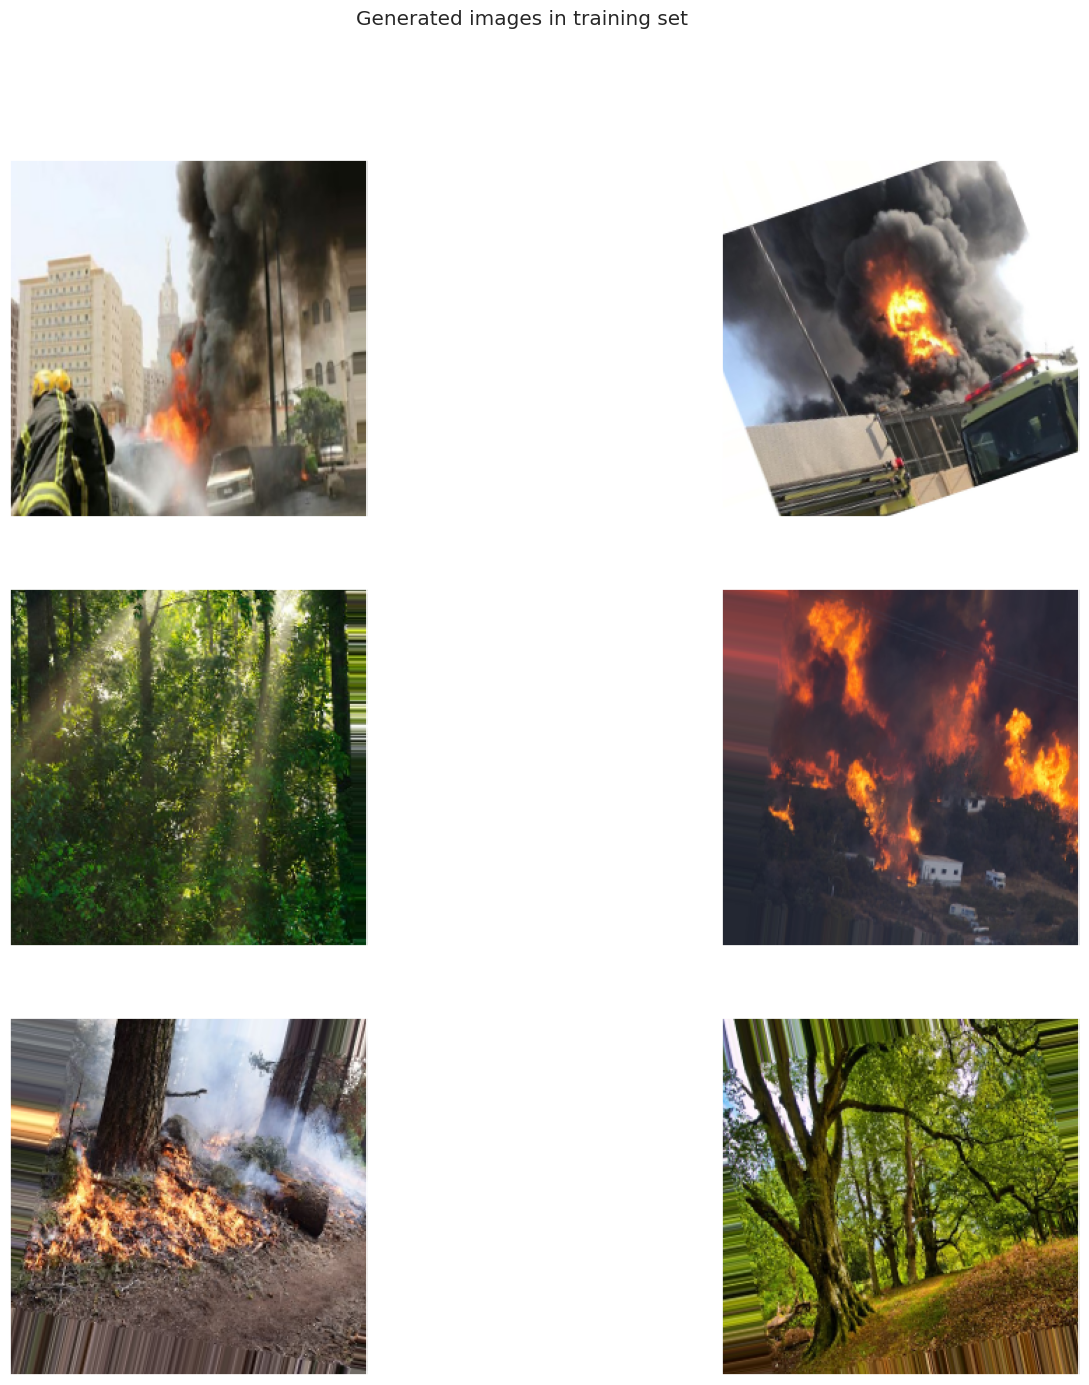

In [17]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

### Model Creation

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [19]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 128)       0

In [21]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [22]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [24]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [25]:
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stopping,reduce_lr_on_plateau])

Epoch 1/15
25/25 [==============================] - 43s 1s/step - loss: 0.3364 - accuracy: 0.8625 - recall: 0.9331 - auc: 0.8999 - val_loss: 0.1002 - val_accuracy: 0.9648 - val_recall: 0.9745 - val_auc: 0.9927 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 32s 1s/step - loss: 0.1685 - accuracy: 0.9388 - recall: 0.9615 - auc: 0.9727 - val_loss: 0.1175 - val_accuracy: 0.9548 - val_recall: 0.9618 - val_auc: 0.9921 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 32s 1s/step - loss: 0.1180 - accuracy: 0.9488 - recall: 0.9682 - auc: 0.9887 - val_loss: 0.1068 - val_accuracy: 0.9548 - val_recall: 0.9554 - val_auc: 0.9923 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 30s 1s/step - loss: 0.1068 - accuracy: 0.9550 - recall: 0.9799 - auc: 0.9912 - val_loss: 0.0956 - val_accuracy: 0.9598 - val_recall: 0.9682 - val_auc: 0.9835 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 34s 1s/step - loss: 0.1106 - accuracy: 0.9550 - recall: 

## Model Evaluation

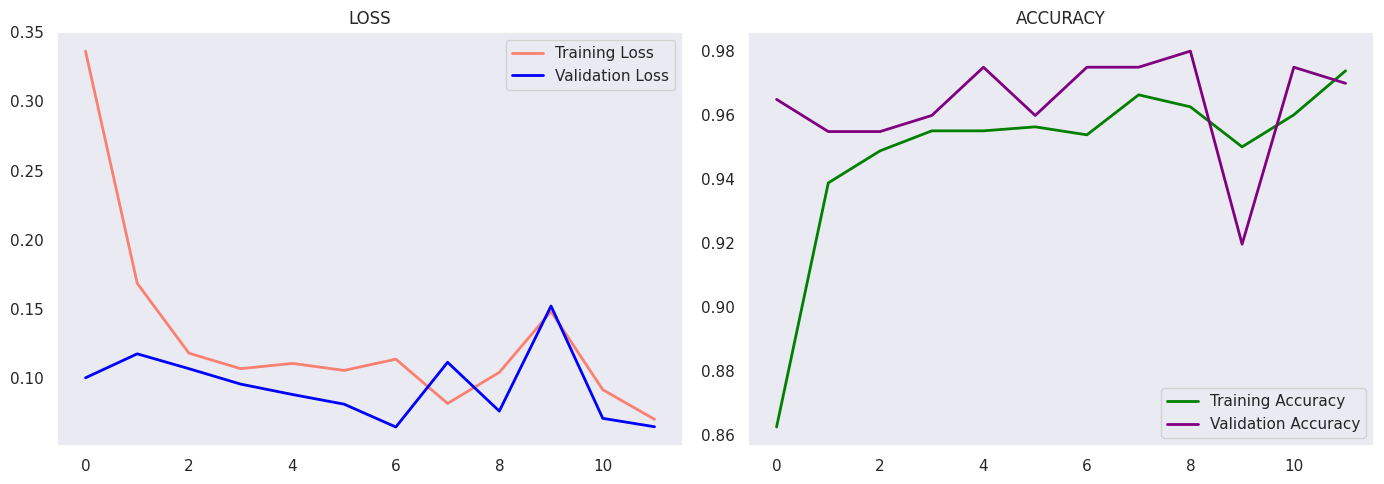

In [26]:
history = model.history

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('LOSS')
ax[1].set_title('ACCURACY')

# Plot training loss and validation loss
ax[0].plot(history.history['loss'], label='Training Loss', color='salmon', lw=2)
ax[0].plot(history.history['val_loss'], label='Validation Loss', color='blue', lw=2)

# Plot training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='green', lw=2)
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple', lw=2)

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()


In [27]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 7s 935ms/step - loss: 0.0700 - accuracy: 0.9799 - recall: 0.9936 - auc: 0.9949
loss: 0.07
accuracy: 0.98
recall: 0.99
auc: 0.99


## Observation :
As the number of epochs increases, both the training accuracy and validation accuracy tend to improve, while the training loss and validation loss generally decrease.

## Model creation by transfer learning

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

In [29]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the weights of the pre-trained layers
for layer in resnet50.layers:
    layer.trainable = False

# Create a custom classification head
x = Flatten()(resnet50.output)
x = Dense(64, activation='relu')(x)
output_to_model = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs=resnet50.input, outputs=output_to_model)

94765736/94765736 [==============================] - 0s 0us/step


In [30]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), AUC()])

In [31]:
history_1 = model_1.fit(x=train_gen, batch_size=32, epochs=15, callbacks=[early_stopping, reduce_lr_on_plateau], validation_data=val_gen)


Epoch 1/15
25/25 [==============================] - 42s 1s/step - loss: 1.5857 - accuracy: 0.5788 - recall_1: 0.6472 - auc_1: 0.5318 - val_loss: 0.6650 - val_accuracy: 0.7889 - val_recall_1: 1.0000 - val_auc_1: 0.9122 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 31s 1s/step - loss: 0.6919 - accuracy: 0.7475 - recall_1: 1.0000 - auc_1: 0.5047 - val_loss: 0.6865 - val_accuracy: 0.7889 - val_recall_1: 1.0000 - val_auc_1: 0.5064 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 32s 1s/step - loss: 0.5618 - accuracy: 0.7475 - recall_1: 1.0000 - auc_1: 0.6282 - val_loss: 0.4055 - val_accuracy: 0.7889 - val_recall_1: 1.0000 - val_auc_1: 0.8566 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 31s 1s/step - loss: 0.4713 - accuracy: 0.7475 - recall_1: 1.0000 - auc_1: 0.8049 - val_loss: 0.3669 - val_accuracy: 0.7889 - val_recall_1: 1.0000 - val_auc_1: 0.8888 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 32s 1s/step - loss: 0.40

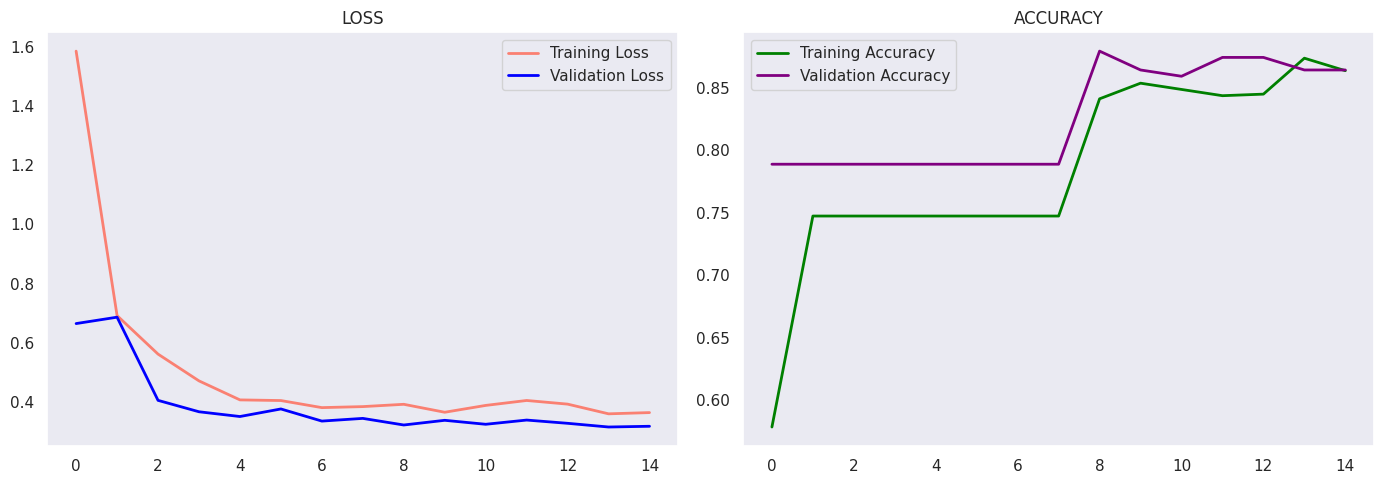

In [33]:
history = history_1  # Replacing 'history_1' with the actual history data for model_1

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('LOSS')
ax[1].set_title('ACCURACY')

ax[0].plot(history.history['loss'], label='Training Loss', color='salmon', lw=2)
ax[0].plot(history.history['val_loss'], label='Validation Loss', color='blue', lw=2)

ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='green', lw=2)
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple', lw=2)

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()


In [34]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 8s 1s/step - loss: 0.0718 - accuracy: 0.9698 - recall: 0.9873 - auc: 0.9950
loss: 0.07
accuracy: 0.97
recall: 0.99
auc: 0.99


 ## Observation :
 After training both models, we observed that the ResNet-based pre-trained model and the model trained from scratch achieved similar AUC scores of 0.99, indicating excellent discrimination ability. However, the model trained from scratch exhibited slightly higher accuracy (0.98) compared to the pre-trained ResNet model (0.97). This suggests that the custom model, initialized from scratch, may have learned the task with a slight advantage in accuracy while maintaining comparable AUC and recall (0.99)

# Example Prediction

#### We will now take a photo and our model will try to predict whether its a fire image or a non fire image

image link - https://newsmobile.in/wp-content/uploads/2017/06/gty_east_village_fire_tl_150327_16x9_992.jpg

In [35]:
!curl https://newsmobile.in/wp-content/uploads/2017/06/gty_east_village_fire_tl_150327_16x9_992.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92183  100 92183    0     0  71464      0  0:00:01  0:00:01 --:--:-- 71515


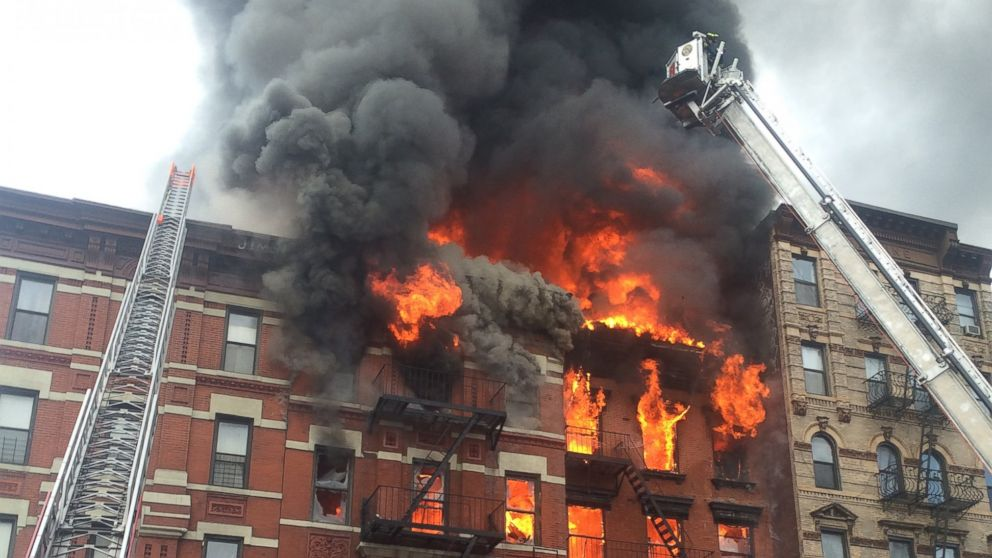

In [36]:
# Printing the image
img = image.load_img('predict.jpg')
img

Resizing the image and expanding its dimension to include the batch size - 1

In [39]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


## Prediction

In [41]:
prediction = int(tf.round(model_1.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 3s 3s/step
The predicted value is:  1 and the predicted label is: fire


# **Thank** **You**